# Recommendation Systems

Companies like Amazon(books, items), Netflix(movies), Google(News,Search), and Pandora/Spotify(music) leverage recommendation systems to help users discover new and relevant items (products, videos, jobs, music), creating a delightful user experience while driving incremental revenue. 

The need to build robust recommendation systems is extremely important given the huge demand for personalized content of modern consumers.


In this assignment, you will be applying your learning of recommendation systems in this Unit towards building the following four different types of recommendation systems:

1.   Global Recommendation Systems (Statistical)   
2.   Content-based Recommendation Systems
3.   Collaborative Filtering (User-Item) Recommendation Systems
4.   Hybrid Recommendation Systems

The focus of the mini-project here would be to build a movie recommendation system.


## 1. Dataset Acquisition

Following are the key descriptions of the datasets you will be using. The data used here has been compiled from various movie datasets like Netflix and IMDb.

1. __Filename: `movie_titles.csv`:__

  - __`MovieID`__: MovieID does not correspond to actual Netflix movie ids or IMDB movie ids
  - __`YearOfRelease`__: YearOfRelease can range from 1890 to 2005 and may correspond to the release of corresponding DVD, not necessarily its theaterical release
  - __`Title`__: Title is the Netflix movie title and may not correspond to titles used on other sites. Titles are in English


2. __Combined User-Ratings Dataset Description - `combined_data.csv`:__

  - The first line of the contains the movie id followed by a colon.    
  - Each subsequent line in the file corresponds to a rating from a customer and its date in the following format:

    - MovieIDs range from 1 to 17770 sequentially.
    - CustomerIDs range from 1 to 2649429, with gaps. There are 480189 users. 
    - Ratings are on a five star (integral) scale from 1 to 5.
    - Dates have the format YYYY-MM-DD.


3. __Filename: `movies_metadata.csv`__

The main Movies Metadata file. Contains information on 45,000 movies featured in the Full MovieLens dataset. Features include posters, backdrops, budget, revenue, release dates, languages, production countries and companies.


## 2: Import Necessary Dependencies

We will be leveraging __`keras`__ on top of __`tensorflow`__ for building some of the collaborative filtering and hybrid models. There are compatibility issues with handling sparse layers with dense layers till now in TensorFlow 2 hence we are leveraging native Keras but in the long run once this issue is resolved we can leverage __`tf.keras`__ with minimal code updates.

In [1]:
# filter out unncessary warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# To store\load the data
import pandas as pd

# To do linear algebra
import numpy as np

# To create plots
import matplotlib.pyplot as plt
import seaborn as sns


# To compute similarities between vectors
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# data load progress bars
from tqdm import tqdm

from collections import deque

# To create deep learning models
import tensorflow as tf
import keras
from keras.layers import Input, Embedding, Reshape, Dot, Concatenate, Dense, Dropout
from keras.models import Model

# To stack sparse matrices
from scipy.sparse import vstack

In [3]:
# remove unnecessary TF logs
import logging
tf.get_logger().setLevel(logging.ERROR)

In [4]:
# check keras and TF version used
print('TF Version:', tf.__version__)
print('Keras Version:', keras.__version__)
# TF Version: 1.15.0
# Keras Version: 2.2.5

TF Version: 2.7.0
Keras Version: 2.7.0


Let's start loading data that will be used for building the recommendation systems

# 3. Load Datasets

## 3.1: Load Movie Metadata Datasets

First, we will load the movie_titles.csv data from the Netflix prize data source

In [5]:
abs_dir = r'/Users/robbytong/Documents/MachineLearning/Sections/CH3 PreparingData/MiniProjects/mec-mini-projects/mec-17.4.1-recommendation-systems-mini-project'

In [6]:
filename = abs_dir + '/data/movie_titles.csv'

print(filename)

# Load data for all movies
movie_titles = pd.read_csv(filename, 
                           encoding = 'ISO-8859-1', 
                           header = None,
                           lineterminator='\n',
                           names = ['Id', 'Year', 'Name', 'Extra1', 'Extra2', 'Extra3']).set_index('Id')

movie_titles.fillna('', inplace=True)

movie_titles['Name'] = \
movie_titles['Name'] + \
movie_titles['Extra1'] + \
movie_titles['Extra2'] + \
movie_titles['Extra3']

movie_titles.drop('Extra1', axis=1, inplace=True)
movie_titles.drop('Extra2', axis=1, inplace=True)
movie_titles.drop('Extra3', axis=1, inplace=True)


print('Shape Movie-Titles:\t{}'.format(movie_titles.shape))
movie_titles.sample(5)

/Users/robbytong/Documents/MachineLearning/Sections/CH3 PreparingData/MiniProjects/mec-mini-projects/mec-17.4.1-recommendation-systems-mini-project/data/movie_titles.csv
Shape Movie-Titles:	(17770, 2)


,Year,Name
Id,,
4826,1992.0,Whispers in the Dark
16865,2003.0,Blue Car
17341,1983.0,Zelig
9659,2004.0,Britney Spears: Greatest Hits: My Prerogative
1084,2001.0,Walking with Prehistoric Beasts


There are approximately 18000 movies in the ratings dataset and the metadata information includes the year of release and movie title

Next, we will load the movie_metadata.csv from The movies dataset source. This is to get the metadata information like description etc. related to each movie.

In [7]:
# Load a movie metadata dataset
movie_metadata = (pd.read_csv('./data/movies_metadata.csv.zip', 
                              low_memory=False)[['original_title', 'overview', 'vote_count']]
                    .set_index('original_title')
                    .dropna())


In [8]:
movie_metadata.head()

,overview,vote_count
original_title,,
Toy Story,"Led by Woody, Andy's toys live happily in his ...",5415.0
Jumanji,When siblings Judy and Peter discover an encha...,2413.0
Grumpier Old Men,A family wedding reignites the ancient feud be...,92.0
Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",34.0
Father of the Bride Part II,Just when George Banks has recovered from his ...,173.0


In [9]:
# Remove the long tail of rarly rated moves
movie_metadata = movie_metadata[movie_metadata['vote_count']>10].drop('vote_count', axis=1)

print('Shape Movie-Metadata:\t{}'.format(movie_metadata.shape))
movie_metadata.sample(5)

Shape Movie-Metadata:	(21604, 1)


,overview
original_title,
Get Me Roger Stone,From his days of testifying at the Watergate h...
The Makeover,"This is an update of George Bernard Shaw's ""Py..."
"광해, 왕이 된 남자",During the confusing and conspiratorial Joseon...
Bleed for This,The inspirational story of World Champion Boxe...
テルマエ・ロマエ,The story follows a Roman architect named Luci...


In [10]:
movie_metadata.sample()['overview'][0]

'The grass might not be as green as one might think on the other side of obesity. Pretty Ugly People takes a wickedly comedic look at body image, self-loathing and sex within a group of estranged friends in their mid-30s. Lucy was obese her entire life and had always longed to be a thin so she could finally lose her virginity.'

Around 21,000 entries in the movies metadata dataset

## 3.2: Load User-Movie-Rating Dataset

In [11]:
# Dowload large file from the shared GDrive folder
!pip install gdown
!gdown "https://drive.google.com/uc?export=download&id=1z0O0fXuofdsbpL8fkCVgjeIwFP_LxGX2" -O data/


Downloading...
From: https://drive.google.com/uc?export=download&id=1z0O0fXuofdsbpL8fkCVgjeIwFP_LxGX2
To: /Users/robbytong/Documents/MachineLearning/Sections/CH3 PreparingData/MiniProjects/mec-mini-projects/mec-17.4.1-recommendation-systems-mini-project/data/combined_data.csv.zip
100%|████████████████████████████████████████| 161M/161M [00:11<00:00, 14.4MB/s]


In [12]:
# Load single data-file
df_raw = pd.read_csv('./data/combined_data.csv.zip', 
                     header=None, 
                     names=['User', 'Rating', 'Date'], 
                     usecols=[0, 1, 2])


In [13]:
df_raw.iloc[1:548].iloc[-1]

User         1815755
Rating           5.0
Date      2004-07-20
Name: 547, dtype: object

In [14]:
# Find empty rows to slice dataframe for each movie
tmp_movies = df_raw[df_raw['Rating'].isna()]['User'].reset_index()
movie_indices = [[index, int(movie[:-1])] for index, movie in tmp_movies.values]


In [15]:
movie_indices

[[0, 1],
 [548, 2],
 [694, 3],
 [2707, 4],
 [2850, 5],
 [3991, 6],
 [5011, 7],
 [5105, 8],
 [20016, 9],
 [20112, 10],
 [20362, 11],
 [20561, 12],
 [21108, 13],
 [21234, 14],
 [21353, 15],
 [21644, 16],
 [24344, 17],
 [31453, 18],
 [42176, 19],
 [42716, 20],
 [42833, 21],
 [43052, 22],
 [43256, 23],
 [43872, 24],
 [45206, 25],
 [46414, 26],
 [52276, 27],
 [52550, 28],
 [92303, 29],
 [92827, 30],
 [211241, 31],
 [211463, 32],
 [213318, 33],
 [220209, 34],
 [220318, 35],
 [221158, 36],
 [222098, 37],
 [222380, 38],
 [223183, 39],
 [223936, 40],
 [224428, 41],
 [224522, 42],
 [224651, 43],
 [224757, 44],
 [233259, 45],
 [235879, 46],
 [242438, 47],
 [244789, 48],
 [248381, 49],
 [248613, 50],
 [248942, 51],
 [249033, 52],
 [254181, 53],
 [254296, 54],
 [254456, 55],
 [256863, 56],
 [258697, 57],
 [262260, 58],
 [279666, 59],
 [279871, 60],
 [280167, 61],
 [280315, 62],
 [280606, 63],
 [280791, 64],
 [280887, 65],
 [281146, 66],
 [281313, 67],
 [281603, 68],
 [283820, 69],
 [283937, 70],
 [

`class collections.dequeue([iterable[, maxlen]])`
Returns a new deque object initialized left to right (using append()) with data from iterable.

In [16]:
# Shift the movie_indices by one to get start and endpoints of all movies
shifted_movie_indices = deque(movie_indices)
shifted_movie_indices.rotate(-1)


In [17]:
import time

# Gather all dataframes
user_data = []

counter = 0
print_time = time.time() + 5

# Iterate over all movies
for (df_id_1, movie_id), (df_id_2, next_movie_id) in zip(movie_indices, shifted_movie_indices):
    # now we have access to the start and stop indices that group
    # together movie ratings from various users for a movie_id
    
    # Check if it is the last movie in the file
    if df_id_1<df_id_2:
        # Normal chunk of ratings
        tmp_df = df_raw.loc[df_id_1+1:df_id_2]
    else:
        # Next index wrapped around indicating 
        # This is the last chunk of ratings
        tmp_df = df_raw.loc[df_id_1+1:].copy()
    
    # Create movie_id column
    tmp_df['Movie'] = movie_id
    
    # Append dataframe to list
    user_data.append(tmp_df)
    
    counter += 1
    
    if time.time() > print_time:
        print_time = time.time() + 5
        
        total = len(movie_indices)
        complete = counter / total * 100
        
        print('[%d / %d: %.3f]'%(counter, total, complete))

# Combine all dataframes
df = pd.concat(user_data, axis=0)

del user_data, df_raw, tmp_movies, tmp_df, shifted_movie_indices, movie_indices, df_id_1, movie_id, df_id_2, next_movie_id
print('Shape User-Ratings: ', df.shape)

[136 / 4499: 3.023]
[312 / 4499: 6.935]
[527 / 4499: 11.714]
[740 / 4499: 16.448]
[917 / 4499: 20.382]
[1081 / 4499: 24.028]
[1274 / 4499: 28.317]
[1471 / 4499: 32.696]
[1670 / 4499: 37.119]
[1878 / 4499: 41.743]
[2091 / 4499: 46.477]
[2311 / 4499: 51.367]
[2527 / 4499: 56.168]
[2752 / 4499: 61.169]
[2974 / 4499: 66.104]
[3194 / 4499: 70.994]
[3408 / 4499: 75.750]
[3621 / 4499: 80.485]
[3835 / 4499: 85.241]
[4051 / 4499: 90.042]
[4270 / 4499: 94.910]
[4490 / 4499: 99.800]
Shape User-Ratings:  (24058262, 4)


In [18]:
df.head(20)

,User,Rating,Date,Movie
1,1488844,3.0,2005-09-06,1
2,822109,5.0,2005-05-13,1
3,885013,4.0,2005-10-19,1
4,30878,4.0,2005-12-26,1
5,823519,3.0,2004-05-03,1
6,893988,3.0,2005-11-17,1
7,124105,4.0,2004-08-05,1
8,1248029,3.0,2004-04-22,1
9,1842128,4.0,2004-05-09,1
10,2238063,3.0,2005-05-11,1


There are about 24 Million+ different rating records!

We have taken the data required for building the system and now let's do some EDA on the dataset to better understand our data

# 4. Exploratory Data Analysis

## 4.1: When were the movies released?


In [19]:
# Remove rows that have blank strings for the Year
movie_titles = movie_titles['' != movie_titles['Year']]

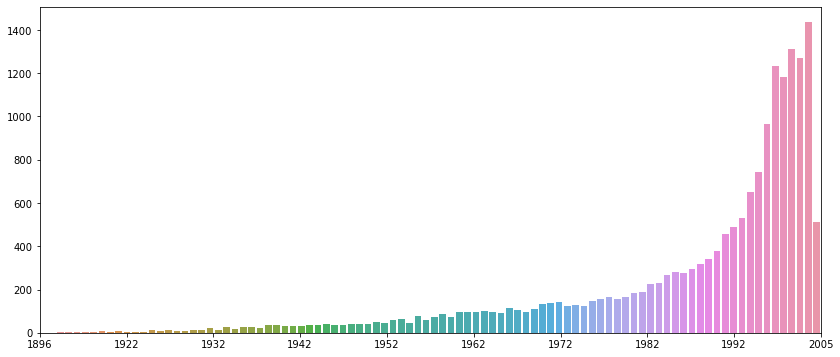

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

data = movie_titles['Year'].value_counts().sort_index()
x = data.index.map(int)
y = data.values

sns.barplot(x, y)
xmin, xmax = plt.xlim()
xtick_labels = [x[0]] + list(x[10:-10:10]) + [x[-1]]
plt.xticks(ticks=np.linspace(xmin, xmax, 10), labels=xtick_labels);

Many movies on Netflix have been released in this millennial. Whether Netflix prefers young movies or there are no old movies left can not be deduced from this plot.
The decline for the rightmost point is probably caused by an incomplete last year.

## Q 4.2: How are The Ratings Distributed?

__Your Turn:__ Build the visualization for rating distributions similar to the previous plot.


In [21]:
movie_titles.head()

,Year,Name
Id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


In [22]:
df.head()

,User,Rating,Date,Movie
1,1488844,3.0,2005-09-06,1
2,822109,5.0,2005-05-13,1
3,885013,4.0,2005-10-19,1
4,30878,4.0,2005-12-26,1
5,823519,3.0,2004-05-03,1


In [23]:
counts = df['Rating'].value_counts().sort_index()

In [24]:
total_counts = np.sum(counts.values)

<AxesSubplot:>

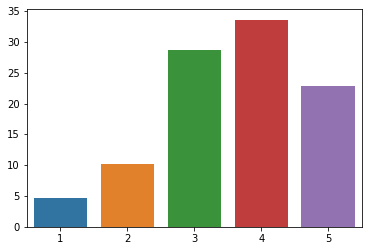

In [25]:
x = counts.index.map(int)
y = counts.values / total_counts * 100.0

sns.barplot(x, y)

Netflix movies rarely have a rating lower than three. Most ratings have between three and four stars.
The distribution is probably biased, since only people liking the movies proceed to be customers and others presumably will leave the platform.

## 4.3: Visualize the Distribution of Number of Movie Ratings 

This is to understand how many movies (y-axis) are receiving specific number of movie ratings (x-axis)

In [26]:
df.groupby('Movie')['Rating'].count()

Movie
1        547
2        145
3       2012
4        142
5       1140
        ... 
4495     614
4496    9519
4497     714
4498     269
4499     428
Name: Rating, Length: 4499, dtype: int64

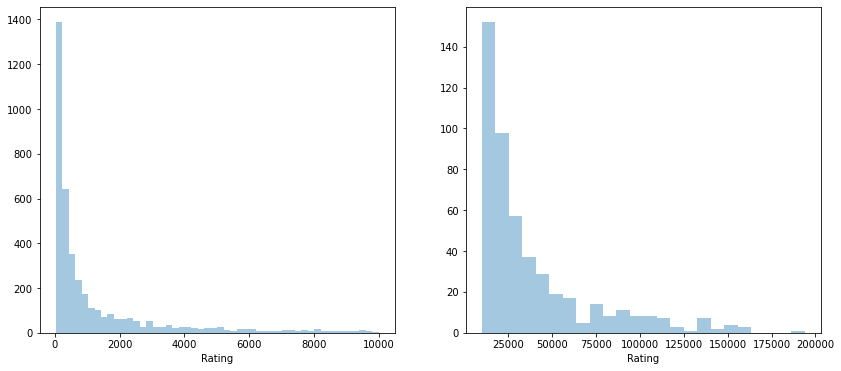

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

data = df.groupby('Movie')['Rating'].count()
sns.distplot(data[data  < 10000], kde=False, ax=ax[0]);
sns.distplot(data[data  > 10000], kde=False, ax=ax[1]);

This just says that most movies get few number of users who actually rate it

## Q 4.4: Visualize the Distribution of Number of User Ratings 

This is to understand how many users (y-axis) are giving specific number of movie ratings (x-axis)

__Your Turn:__ Try to find out an optimal threshold as in the previous example to split the data to form two understandable subplots!

In [28]:
counts = df.groupby('User')['Rating'].count()

<AxesSubplot:xlabel='Rating'>

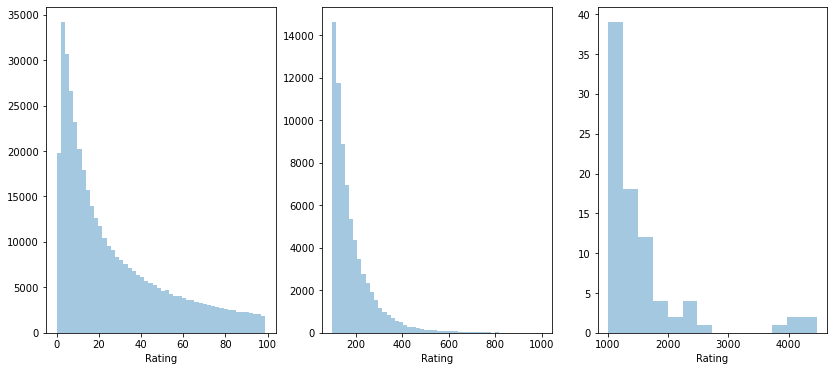

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(14, 6))

div = 100

sns.distplot(counts[counts <  100], kde=False, ax=ax[0])
sns.distplot(counts[(100 <= counts) & (counts < 1000)], kde=False, ax=ax[1])
sns.distplot(counts[1000 <= counts], kde=False, ax=ax[2])

The ratings per movie as well as the ratings per user both have nearly a perfect exponential decay. Only very few movies/users have many ratings.

# 5. Dimensionality Reduction & Filtering

## Filter Sparse Movies And Users

To reduce the dimensionality of the dataset I am filtering rarely rated movies and rarely rating users out.


In [30]:
# Get list of movies with more than 1000 ratings
min_movie_ratings = 1000
filter_movies = df['Movie'].value_counts() > min_movie_ratings
filter_movies = filter_movies[filter_movies].index.tolist()

In [31]:
# Get list of users with more than 100 ratings
min_user_ratings = 200
filter_users = df['User'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

In [32]:
# Use the lists to filter the data
movie_mask = df['Movie'].isin(filter_movies)
user_mask = df['User'].isin(filter_users)

mask = movie_mask & user_mask

df_filtered = df[mask]

del filter_movies, filter_users, min_movie_ratings, min_user_ratings, movie_mask, user_mask, mask

In [33]:
print('Filtered df shape: ', df_filtered.shape)
print('Un-filte df shape: ', df.shape)

Filtered df shape:  (5930952, 4)
Un-filte df shape:  (24058262, 4)


After filtering sparse movies and users about 5.9M rating records are present.

# 6. Create Train and Test Datasets

Do note this will be used for the statistical method based models and collaborative filtering.

For content based filtering it is more of a model which recommends movies rather than predicting ratings and for the hybrid model we will need to recreate the train and test datasets later since we need to create a subset of movies-users-ratings which have movie text descriptions.

## Create Train and Test datasets

In [34]:
# Shuffle DataFrame
df_filtered = df_filtered.drop('Date', axis=1).sample(frac=1).reset_index(drop=True)

In [35]:
df_filtered.shape

(5930952, 3)

In [36]:
df_filtered.head(5)

,User,Rating,Movie
0,1240094,2.0,2457
1,508852,1.0,3264
2,406365,4.0,2254
3,1248029,3.0,3433
4,2509840,4.0,3323


In [37]:
# Testingsize
n = 100000

df_train = df_filtered.iloc[:n]
df_test  = df_filtered.iloc[n:]

In [38]:
print('train size: ', df_train.shape)
print('test  size: ', df_test.shape)

train size:  (100000, 3)
test  size:  (5830952, 3)


The train set will be used to train all models and the test set ensures we can compare model performance on unseen data using the RMSE metric.

# 7. Transformation

### Q 7.1: Transform The User-Movie-Ratings Data Frame to User-Movie Matrix

A large, sparse matrix will be created in this step. Each row will represent a user and its ratings and the columns are the movies.

The movies already rated by users are the non-empty values in the matrix.

Empty values are unrated movies and the main objective is to estimate the empty values to help our users.


__Your turn:__ Create the User-Movie matrix leveraging the __`pivot_table()`__ function from pandas.

Fill in the blanks in the code below by referencing the __`pivot_table()`__ function and invoking it on __`df_train`__. Feel free to check out the documentation.

Remember, rows should be users, columns should be movies and the values in the matrix should be the movie ratings. All these should be available in the __`df_train`__ dataframe.

In [39]:
df_p = df_train.pivot_table(index='User', columns='Movie')

In [40]:
df_p.shape

(20520, 1741)

In [41]:
df_p.head()

Rating                                               ...            \
Movie     3    5    6    8    16   17   18   24   25   26    ... 4482 4483   
User                                                         ...             
1000079    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
1000192    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
1000301    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
1000387    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
1000410    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   

                                                 
Movie   4484 4485 4488 4489 4490 4492 4493 4496  
User                                             
1000079  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1000192  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1000301  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1000387  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1000410  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[5 rows x 1741 columns]

## 8. Building Recommendation Systems

## 8.1(a): Global Recommendation Systems (Mean Rating)

Computing the mean rating for all movies creates a ranking. The recommendation will be the same for all users and can be used if there is no information on the user.
Variations of this approach can be separate rankings for each country/year/gender/... and to use them individually to recommend movies/items to the user.

It has to be noted that this approach is biased and favours movies with fewer ratings, since large numbers of ratings tend to be less extreme in its mean ratings.

### Additional Hint

Predict model performance: [mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)

In [42]:
ratings_mean = df_p.mean(axis=0).sort_values(ascending=False).rename('Rating-Mean').to_frame()

In [43]:
ratings_mean.head()

Rating-Mean
       Movie             
Rating 4340      5.000000
       4449      4.666667
       1660      4.500000
       325       4.500000
       1947      4.500000

In [44]:
ratings_count = df_p.count(axis=0).sort_values(ascending=False).rename('Rating-Freq').to_frame()

In [45]:
ratings_count.head()

Rating-Freq
       Movie             
Rating 1905           362
       2372           328
       2152           316
       571            309
       4306           306

In [46]:
movie_titles.iloc[4238]

Year       1973.0
Name    Maitresse
Name: 4239, dtype: object

In [47]:
# combine the aggregated dataframes
combined_df = ratings_mean.join(ratings_count).join(movie_titles, on='Movie')

In [48]:
combined_df.head(5)

Rating-Mean  Rating-Freq    Year  \
       Movie                                     
Rating 4340      5.000000            3  2000.0   
       4449      4.666667            3  2002.0   
       1660      4.500000           16  2000.0   
       325       4.500000            2  2004.0   
       1947      4.500000           24  2002.0   

                                                           Name  
       Movie                                                     
Rating 4340                                           Longitude  
       4449   The Inspector Lynley Mysteries: For the Sake o...  
       1660                     SpongeBob SquarePants: Season 2  
       325                          Ghosts of Rwanda: Frontline  
       1947                             Gilmore Girls: Season 3

In [49]:
combined_df[combined_df['Rating-Freq'] > 100]

Rating-Mean  Rating-Freq    Year  \
       Movie                                     
Rating 3290      4.402844          211  1974.0   
       2172      4.396040          101  1991.0   
       3962      4.371134          291  2003.0   
       2452      4.369338          287  2001.0   
       4306      4.307190          306  1999.0   
...                   ...          ...     ...   
       3085      2.714286          147  2000.0   
       1975      2.703540          226  2000.0   
       1289      2.580000          150  1990.0   
       2400      2.471545          123  1992.0   
       2675      2.272000          125  2002.0   

                                                       Name  
       Movie                                                 
Rating 3290                           The Godfather Part II  
       2172                          The Simpsons: Season 3  
       3962                       Finding Nemo (Widescreen)  
       2452   Lord of the Rings: The Fellowship of the Ring  
       4306                                 The Sixth Sense  
...                                                     ...  
       3085                                    Little Nicky  
       1975                                      Hollow Man  
       1289                          Look Who's Talking Too  
       2400                  Home Alone 2: Lost in New York  
       2675                                         Solaris  

[338 rows x 4 columns]

In [50]:
ratings_mean = ratings_mean.reset_index().set_index('Movie').drop(columns='level_0')

In [51]:
ratings_mean.isnull().sum(axis=0)

Rating-Mean    0
dtype: int64

In [52]:
df_test.isnull().sum(axis=0)

User      0
Rating    0
Movie     0
dtype: int64

In [53]:
predictions_df = df_train.set_index('Movie').join(ratings_mean, on='Movie')

In [54]:
# Compute RMSE
y_true = predictions_df['Rating']
y_pred = predictions_df['Rating-Mean']

rmse = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred))
print("The RMSE Value for the Mean Rating Recommender:", rmse)

The RMSE Value for the Mean Rating Recommender: 0.9988508327253743


In [55]:
# View top ten rated movies
combined_df[['Name', 'Rating-Mean']].head(10)

Name  Rating-Mean
       Movie                                                                
Rating 4340                                           Longitude     5.000000
       4449   The Inspector Lynley Mysteries: For the Sake o...     4.666667
       1660                     SpongeBob SquarePants: Season 2     4.500000
       325                          Ghosts of Rwanda: Frontline     4.500000
       1947                             Gilmore Girls: Season 3     4.500000
       3057    UFC 43: Ultimate Fighting Championship: Meltdown     4.500000
       2102                              The Simpsons: Season 6     4.500000
       3546                                         Speed Racer     4.500000
       3965                                 Red Dwarf: Series 5     4.500000
       2893                                  The Little Rascals     4.500000

## Q 8.1(b): Global Recommendation Systems (Weighted Rating)

To tackle the problem of the unstable mean with few ratings e.g. IDMb uses a weighted rating. Many good ratings outweigh few in this algorithm.

### Hint:

Weighted Rating Formula

weighted rating (𝑊𝑅)=(𝑣/(𝑣+𝑚))𝑅+(𝑚/(𝑣+𝑚))𝐶

where:

*𝑅* = average for the movie (mean) = (Rating)

*𝑣* = number of votes for the movie = (votes)

*𝑚* = minimum votes required 

*𝐶* = the mean vote across the whole report 

__Your Turn:__ Fill in the necessary code snippets below to build and test the model


In [56]:
df_p.head()

Rating                                               ...            \
Movie     3    5    6    8    16   17   18   24   25   26    ... 4482 4483   
User                                                         ...             
1000079    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
1000192    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
1000301    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
1000387    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
1000410    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   

                                                 
Movie   4484 4485 4488 4489 4490 4492 4493 4496  
User                                             
1000079  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1000192  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1000301  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1000387  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1000410  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[5 rows x 1741 columns]

In [57]:
df_p.stack().mean()

Rating    3.4636
dtype: float64

In [58]:
total_ratings = df_p.notna().sum(axis=0).sum()

sum_of_all_ratings = df_p.sum(axis=0).sum()

mean_rating = sum_of_all_ratings / total_ratings

mean_rating

3.4636

In [59]:
df_p.mean(axis=0).values

array([3.16666667, 3.55555556, 3.28571429, ..., 2.34782609, 3.46875   ,
       3.55769231])

In [60]:
mean_ratings_by_movie = df_p.sum(axis=0) / df_p.notna().sum(axis=0)
mean_ratings_by_movie

        Movie
Rating  3        3.166667
        5        3.555556
        6        3.285714
        8        3.179487
        16       3.076923
                   ...   
        4489     2.785714
        4490     3.215686
        4492     2.347826
        4493     3.468750
        4496     3.557692
Length: 1741, dtype: float64

In [61]:
num_ratings_by_movie = df_p.count()
num_ratings_by_movie

        Movie
Rating  3        12
        5         9
        6         7
        8        39
        16       26
                 ..
        4489     14
        4490     51
        4492     46
        4493     32
        4496     52
Length: 1741, dtype: int64

In [62]:
# Number of minimum votes to be considered
m = 1000

# Mean rating for all movies
C = df_p.stack().mean()[0]

# Mean rating for all movies separately
R = df_p.mean(axis=0).values

# Rating freqency for all movies separately
v = df_p.count().values

In [63]:
# Weighted formula to compute the weighted rating
weighted_score = (v/(v+m))*R + (m/(v+m))*C

weighted_score

array([3.46007905, 3.46442022, 3.46236346, ..., 3.41453155, 3.46375969,
       3.46825095])

In [64]:
df_p.head(1)

Rating                                               ...            \
Movie     3    5    6    8    16   17   18   24   25   26    ... 4482 4483   
User                                                         ...             
1000079    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   

                                                 
Movie   4484 4485 4488 4489 4490 4492 4493 4496  
User                                             
1000079  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[1 rows x 1741 columns]

In [65]:
# convert weighted_score into a dataframe
weighted_mean = pd.DataFrame(weighted_score.reshape(1,-1))
weighted_mean.columns = df_p.columns
weighted_mean = weighted_mean.T

weighted_mean = weighted_mean.reset_index().set_index('Movie').drop(columns='level_0')

weighted_mean.columns = ['WeightedRating']

weighted_mean

,WeightedRating
Movie,
3,3.460079
5,3.464420
6,3.462363
8,3.452936
16,3.453801
...,...
4489,3.454241
4490,3.451570
4492,3.414532


In [66]:
# Combine the aggregated dataframes (wighted_mean & movie_titles)
combined_df = weighted_mean.join(movie_titles)

In [67]:
combined_df.sort_values('WeightedRating', ascending=False).head(10)

,WeightedRating,Year,Name
Movie,,,
3962,3.668164,2003.0,Finding Nemo (Widescreen)
2452,3.665579,2001.0,Lord of the Rings: The Fellowship of the Ring
4306,3.661256,1999.0,The Sixth Sense
2862,3.652502,1991.0,The Silence of the Lambs
1905,3.646549,2003.0,Pirates of the Caribbean: The Curse of the Bla...
3290,3.627250,1974.0,The Godfather Part II
3938,3.623227,2004.0,Shrek 2
2782,3.622639,1995.0,Braveheart
3605,3.610070,1939.0,The Wizard of Oz: Collector's Edition


In [68]:
predictions_df = df_train.set_index('Movie').join(ratings_mean, on='Movie')

In [69]:
weighted_mean

,WeightedRating
Movie,
3,3.460079
5,3.464420
6,3.462363
8,3.452936
16,3.453801
...,...
4489,3.454241
4490,3.451570
4492,3.414532


In [70]:
predictions_df = df_test.set_index('Movie').join(weighted_mean)

In [74]:
predictions_df.isnull().sum(axis=0)

User                0
Rating              0
WeightedRating    185
dtype: int64

In [72]:
predictions_df.head()

,User,Rating,WeightedRating
Movie,,,
3,1825647,4.0,3.460079
3,2005487,1.0,3.460079
3,2203182,3.0,3.460079
3,341649,3.0,3.460079
3,2613654,4.0,3.460079


In [76]:
# Join labels and predictions based on mean movie rating
predictions_df = predictions_df.dropna(axis=0)
predictions_df.head(5)

,User,Rating,WeightedRating
Movie,,,
3,1825647,4.0,3.460079
3,2005487,1.0,3.460079
3,2203182,3.0,3.460079
3,341649,3.0,3.460079
3,2613654,4.0,3.460079


In [77]:
# Compute RMSE
y_true = predictions_df['Rating']
y_pred = predictions_df['WeightedRating']

rmse = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred))
print("The RMSE Value for the Weighted-Mean Rating Recommender:", rmse)

The RMSE Value for the Weighted-Mean Rating Recommender: 1.0641687991025348


In [80]:
# View top ten rated movies
combined_df.sort_values('WeightedRating', ascending=False).head(10)

,WeightedRating,Year,Name
Movie,,,
3962,3.668164,2003.0,Finding Nemo (Widescreen)
2452,3.665579,2001.0,Lord of the Rings: The Fellowship of the Ring
4306,3.661256,1999.0,The Sixth Sense
2862,3.652502,1991.0,The Silence of the Lambs
1905,3.646549,2003.0,Pirates of the Caribbean: The Curse of the Bla...
3290,3.627250,1974.0,The Godfather Part II
3938,3.623227,2004.0,Shrek 2
2782,3.622639,1995.0,Braveheart
3605,3.610070,1939.0,The Wizard of Oz: Collector's Edition


The variable "m" can be seen as regularizing parameter. Changing it determines how much weight is put onto the movies with many ratings.
Even if there is a better ranking the RMSE decreased slightly. There is a trade-off between interpretability and predictive power.

## 8.2: Content Based Recommendation Systems


The Content-Based Recommender relies on the similarity of the items being recommended. The basic idea is that if you like an item, then you will also like a “similar” item. It generally works well when it’s easy to determine the context/properties of each item. If there is no historical data for a user or there is reliable metadata for each movie, it can be useful to compare the metadata of the movies to find similar ones.

![](./images/Content-based.png)

### Cosine TFIDF Movie Description Similarity

#### TF-IDF 

This is a text vectorization technique which is used to determine the relative importance of a document / article / news item / movie etc.

TF is simply the frequency of a word in a document. 

IDF is the inverse of the document frequency among the whole corpus of documents. 

TF-IDF is used mainly because of two reasons: Suppose we search for “the results of latest European Socccer games” on Google. It is certain that “the” will occur more frequently than “soccer games” but the relative importance of soccer games is higher than the search query point of view. 

In such cases, TF-IDF weighting negates the effect of high frequency words in determining the importance of an item (document).

![](./images/TF-IDF-FORMULA.png)


#### Cosine Similarity 
After calculating TF-IDF scores, how do we determine which items are closer to each other, rather closer to the user profile? This is accomplished using the Vector Space Model which computes the proximity based on the angle between the vectors.

Consider the following example

![](./images/vector-space-model.png)

Sentence 2 is more likely to be using Term 2 than using Term 1. Vice-versa for Sentence 1. 

The method of calculating this relative measure is calculated by taking the cosine of the angle between the sentences and the terms. 

The ultimate reason behind using cosine is that the value of cosine will increase with decreasing value of the angle between which signifies more similarity. 

The vectors are length normalized after which they become vectors of length 1 and then the cosine calculation is simply the sum-product of vectors.

In this approch we will use the movie description to create a TFIDF-matrix, which counts and weights words in all descriptions, and compute a cosine similarity between all of those sparse text-vectors. This can easily be extended to more or different features if you like.
It is impossible for this model to compute a RMSE score, since the model does not recommend the movies directly.
In this way it is possible to find movies closly related to each other.

This approach of content based filtering can be extendend to increase the model performance by adding some more features like genres, cast, crew etc.

In [82]:
movie_metadata

,overview
original_title,
Toy Story,"Led by Woody, Andy's toys live happily in his ..."
Jumanji,When siblings Judy and Peter discover an encha...
Grumpier Old Men,A family wedding reignites the ancient feud be...
Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom..."
Father of the Bride Part II,Just when George Banks has recovered from his ...
...,...
L'Homme à la tête de caoutchouc,A chemist in his laboratory places upon a tabl...
Le locataire diabolique,A man rents an apartment and furnishes it in r...
L'Homme orchestre,A band-leader has arranged seven chairs for th...


In [81]:
# view sample movie descriptions
movie_metadata['overview'].head(5)

original_title
Toy Story                      Led by Woody, Andy's toys live happily in his ...
Jumanji                        When siblings Judy and Peter discover an encha...
Grumpier Old Men               A family wedding reignites the ancient feud be...
Waiting to Exhale              Cheated on, mistreated and stepped on, the wom...
Father of the Bride Part II    Just when George Banks has recovered from his ...
Name: overview, dtype: object

In [83]:
# Create tf-idf matrix for text comparison
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movie_metadata['overview'])

In [88]:
movie_metadata.shape

(21604, 1)

In [90]:
tfidf_matrix

<21604x48083 sparse matrix of type '<class 'numpy.float64'>'
	with 574154 stored elements in Compressed Sparse Row format>

In [92]:
similarity = cosine_similarity(tfidf_matrix)

In [94]:
similarity.shape

(21604, 21604)

In [95]:
similarity_df = pd.DataFrame(
    similarity,
    index=movie_metadata.index.values,
    columns=movie_metadata.index.values
)

In [96]:
similarity_df

,Toy Story,Jumanji,Grumpier Old Men,Waiting to Exhale,Father of the Bride Part II,Heat,Sabrina,Tom and Huck,Sudden Death,GoldenEye,...,The Final Storm,In a Heartbeat,"Bloed, Zweet en Tranen",To Be Fat Like Me,Cadet Kelly,L'Homme à la tête de caoutchouc,Le locataire diabolique,L'Homme orchestre,Maa,Robin Hood
Toy Story,1.000000,0.015385,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.023356,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.0
Jumanji,0.015385,1.000000,0.046854,0.000000,0.000000,0.047646,0.000000,0.000000,0.098488,0.000000,...,0.00000,0.000000,0.000000,0.004192,0.0,0.014642,0.000000,0.00000,0.000000,0.0
Grumpier Old Men,0.000000,0.046854,1.000000,0.000000,0.023903,0.000000,0.000000,0.006463,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.0,0.015409,0.000000,0.00000,0.007101,0.0
Waiting to Exhale,0.000000,0.000000,0.000000,1.000000,0.000000,0.007417,0.000000,0.008592,0.000000,0.000000,...,0.02846,0.000000,0.000000,0.000000,0.0,0.000000,0.016324,0.00684,0.000000,0.0
Father of the Bride Part II,0.000000,0.000000,0.023903,0.000000,1.000000,0.000000,0.030866,0.000000,0.033213,0.000000,...,0.00000,0.000000,0.000000,0.022816,0.0,0.000000,0.000000,0.00000,0.012584,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
L'Homme à la tête de caoutchouc,0.000000,0.014642,0.015409,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076444,...,0.00000,0.000000,0.000000,0.004332,0.0,1.000000,0.000000,0.00000,0.000000,0.0
Le locataire diabolique,0.000000,0.000000,0.000000,0.016324,0.000000,0.015837,0.105139,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.00000,0.000000,0.0
L'Homme orchestre,0.000000,0.000000,0.000000,0.006840,0.000000,0.000000,0.000000,0.000000,0.000000,0.016266,...,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.00000,0.000000,0.0
Maa,0.000000,0.000000,0.007101,0.000000,0.012584,0.000000,0.000000,0.006162,0.014963,0.000000,...,0.00000,0.000000,0.013979,0.000000,0.0,0.000000,0.000000,0.00000,1.000000,0.0


In [98]:
movie_list = similarity_df.columns.values

In [99]:
movie = 'Batman Begins'

top_n = 10

movie_sim = similarity_df[similarity_df.index == movie].values[0]

In [106]:
sorted_movie_ids = np.argsort(movie_sim)[::-1]

print('\n'.join(movie_list[sorted_movie_ids][1:top_n+1]))

Batman Unmasked: The Psychology of the Dark Knight
Batman: The Dark Knight Returns, Part 1
Batman: Bad Blood
Batman: Year One
Batman: Under the Red Hood
Batman Beyond: The Movie
Batman Forever
Batman: Mask of the Phantasm
Batman & Bill
Batman


__Your turn:__ Create a function as defined below, __`content_movie_recommender()`__ which can take in sample movie names and print a list of top N recommended movies

array(['Iron Man & Captain America: Heroes United',
       'Captain America: The First Avenger', 'Team Thor',
       'Education for Death', 'Captain America: The Winter Soldier',
       '49th Parallel', 'Ultimate Avengers', 'Philadelphia Experiment II',
       'Vice Versa', 'The Lair of the White Worm'], dtype=object)

In [116]:
def content_movie_recommender(input_movie, similarity_database=similarity_df, movie_database_list=movie_list, top_n=10):
    return [
        movie_database_list[
            np.argsort(
                similarity_database[similarity_database.index==movie].values[0]
            )[::-1]
        ][1:top_n+1]
    
        for movie in input_movie
    ]


__Your turn:__ Test your function below on the given sample movies

In [118]:
sample_movies = ['Captain America', 'The Terminator', 'The Exorcist', 
                 'The Hunger Games: Mockingjay - Part 1', 'The Blair Witch Project']
                 
content_movie_recommender(sample_movies, top_n=20)

[array(['Iron Man & Captain America: Heroes United',
        'Captain America: The First Avenger', 'Team Thor',
        'Education for Death', 'Captain America: The Winter Soldier',
        '49th Parallel', 'Ultimate Avengers', 'Philadelphia Experiment II',
        'Vice Versa', 'The Lair of the White Worm',
        "Will Ferrell: You're Welcome America - A Final Night with George W. Bush",
        '國產凌凌漆', '36 Hours', 'ヤッターマン',
        'Indiana Jones and the Kingdom of the Crystal Skull', 'Белый тигр',
        'Cornered', 'The Ghost Ship', 'Where the Red Fern Grows', 'Mask'],
       dtype=object),
 array(['Terminator 2: Judgment Day', 'Terminator Salvation',
        'Terminator 3: Rise of the Machines', 'Silent House', 'They Wait',
        'Another World', 'Teenage Caveman', 'Appleseed Alpha', 'Respire',
        'Just Married', 'Paradise', 'The Book of Eli', '僕の彼女はサイボーグ',
        'Steel Dawn', 'Dans ton sommeil', "Elle s'appelait Sarah",
        'Beyond Borders', 'The Heart is Deceitf

## 8.3: Collaborative filtering Recommendation Systems

### Collaborative Filtering
Primarily recommends content to you based on inputs or actions from other people(say your friends).
![collaborative filtering](./images/collaborative-filtering.png)



### What is the intuition behind this?

*   **Personal tastes are correlated**


        1.   If Alice and Bob both like X and Alice likes Y then Bob is more likely to like Y
        2.   especially (perhaps) if Bob knows Alice

Types of Collaborative Filtering:


1.   Neighborhood methods
2.   Matrix Factorization (Latent Factor) methods



Assume you dont have users. Rather you have users' characterisics and properties(as shown in image).![Latent Factor method](https://miro.medium.com/max/876/1*AQEx38Wdo5H0WTSjRfAWtA.png)

For example, a person who is brave-hearted is more likely to be interested in dark, horrific movies rather than someone who is soft and compassionate.
* ^This is just an example(not in any literal sense)

So, once you have the properties and characteristics of each user, we call them as lower-dimensional features of the users. Similarly, we can have lower-dimensional features for movies(say its 10% action, 20% romance ...)

With these features, we represent users and movies in a low dimensional space describing their properties. **This is called as the latent space.**

We then recommend a movie based on its proximity to the user in the latent space.

### The problem:

The problem we try to address here is the rating prediction problem. 
Say, we try to guess how much Alice would rate a movie and suggest those movies that we think Alice will rate higher.

### Interesting...But, how do we predict how much Alice would rate a movie?

 The data we have is a rating history: ratings of users for items in the interval [1,5]. We can put all this data into a sparse matrix called R:
 
 $R = 
 \begin{pmatrix}
  3 & ? &? \\ 
  ? & 4 & 5 \\
  ? & ? & 2 \\
  2 & 3 & ?
 \end{pmatrix}
 \begin{matrix}
  Alice \\ 
  Bob \\
  Chand \\
  Deb
 \end{matrix}
 $

 Each row of the matrix corresponds to a given user, and each column corresponds to a given item. For instance here, Alice has rated the first movie with a rating of 3, and Chand has rated the third item with a rating of 2.

 The matrix R is sparse (more than 99% of the entries are missing), and our goal is to predict the missing entries, i.e. predict the ?.


### Anatomy of the Rating matrix: LATENT SPACE
Before predicting ratings, lets step back and understand the latent space more! \\
 In this Rating matrix, Rows represent Users and Columns represent Movies.
 $R = 
  \begin{pmatrix}
  --Alice-- \\ 
  --Bob-- \\
  --Chand-- \\
  --Deb--
 \end{pmatrix}
 $

 In latent space(low dimensional features - fanatics), for instance, Alice could be defined as a little bit of an action fan, a little bit of a comedy fan, a lot of a romance fan, etc. As for Bob, he could be more keen on action movies:

```
Alice = 10% Action fan + 10% Comedy fan + 50% Romance fan + ⋯ \\
Bob = 50% Action fan + 30% Comedy fan + 10% Romance fan + ⋯ \\
: \\
Zoe = ⋯
```

What would happen if we transposed our rating matrix? Instead of having users in the rows, we would now have movies, defined as their ratings.

$
R ^ T = 
  \begin{pmatrix}
  --Avengers-- \\ 
  --Matrix-- \\
  --Inception-- \\
  --Sherlock--
 \end{pmatrix}
$

In the latent space, we will associate a semantic meaning behind each of the  movies, and these semantic meanings(say movie characteristics) can build back all of our original movies.

### EXAMPLE
In the below example, we convert users and movies to vectors(embeddings) and do dot-product to predict R

user vector - U \\
movies vector - V \\
$
R = U.V
$

### Additional hints:

use dataframe map - [map](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.map.html)

Create tensor - [Input](https://www.tensorflow.org/api_docs/python/tf/keras/Input#view-aliases)

Create Embedding - [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)

Dot product - [Dot](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dot)

Fit model : 
[fit](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit)

Measure Performance: [mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)

### Q8.3: Building a Deep Learning Matrix Factorization based Collaborative Filtering Recommendation System

__Your Turn:__ Fill in the necessary blank code snippets in the following sections to train your own DL collaborative  filtering system

#### Create Configuration Parameters

In [125]:
df_filtered.head()

,User,Rating,Movie
0,1240094,2.0,2457
1,508852,1.0,3264
2,406365,4.0,2254
3,1248029,3.0,3433
4,2509840,4.0,3323


In [126]:
# Create user and movie-id mapping to convert to numbers
user_id_mapping  = {id:i for i, id in enumerate(df_filtered['User' ].unique())}
movie_id_mapping = {id:i for i, id in enumerate(df_filtered['Movie'].unique())}

In [127]:
# use dataframe map function to map users & movies to mapped ids based on above mapping
train_user_data  = df_train['User' ].map(user_id_mapping)
train_movie_data = df_train['Movie'].map(movie_id_mapping)

In [130]:
# do the same for test data
test_user_data  = df_test['User' ].map(user_id_mapping)
test_movie_data = df_test['Movie'].map(movie_id_mapping)

In [144]:
# Get input variable-sizes
users = len(user_id_mapping)
movies = len(movie_id_mapping)
embedding_size = 100

In [145]:
users

20828

In [146]:
movies

1742

#### Construct Deep Learning Model Architecture

In [147]:
# use Input() to create tensors for - 'user' and 'movie'
user_id_input = Input(shape=(1,), name='user')
movie_id_input = Input(shape=(1,), name='movie')

In [148]:
# Create embedding layer for users 
user_embedding = Embedding(output_dim=embedding_size, 
                           input_dim=users,
                           input_length=1, 
                           name='user_embedding')(user_id_input)


# create embedding layer for movies just like users
movie_embedding = Embedding(output_dim=embedding_size, 
                           input_dim=movies,
                           input_length=1, 
                           name='movie_embedding')(movie_id_input)


2022-03-20 23:10:06.499419: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [149]:
user_embedding

<KerasTensor: shape=(None, 1, 100) dtype=float32 (created by layer 'user_embedding')>

In [151]:
# Reshape the embedding layers
user_vector = Reshape([embedding_size])(user_embedding)
movie_vector = Reshape([embedding_size])(movie_embedding)

In [152]:
# Compute dot-product of reshaped embedding layers as prediction
y = Dot(1, normalize=False)([user_vector, movie_vector])

In [153]:
# Setup model
model = Model(inputs=[user_id_input, movie_id_input], outputs=y)
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 movie (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 100)       2082800     ['user[0][0]']                   
                                                                                                  
 movie_embedding (Embedding)    (None, 1, 100)       174200      ['movie[0][0]']                  
                                                                                              

#### Train and Test the Model

In [156]:
# Fit model
X = [train_user_data, train_movie_data]
y = df_train['Rating']

batch_size = 1024
epochs = 10
validation_split = 0.1

model.fit(X, y,
          batch_size=batch_size, 
          epochs=epochs,
          validation_split=validation_split,
          shuffle=True,
          verbose=1)

Epoch 1/10
88/88 [==============================] - 3s 36ms/step - loss: 0.1586 - val_loss: 3.8056
Epoch 2/10
88/88 [==============================] - 3s 34ms/step - loss: 0.1200 - val_loss: 3.8062
Epoch 3/10
88/88 [==============================] - 3s 33ms/step - loss: 0.0912 - val_loss: 3.8156
Epoch 4/10
88/88 [==============================] - 3s 32ms/step - loss: 0.0694 - val_loss: 3.8289
Epoch 5/10
88/88 [==============================] - 3s 35ms/step - loss: 0.0528 - val_loss: 3.8420
Epoch 6/10
88/88 [==============================] - 3s 33ms/step - loss: 0.0401 - val_loss: 3.8581
Epoch 7/10
88/88 [==============================] - 3s 36ms/step - loss: 0.0304 - val_loss: 3.8720
Epoch 8/10
88/88 [==============================] - 3s 35ms/step - loss: 0.0230 - val_loss: 3.8865
Epoch 9/10
88/88 [==============================] - 3s 34ms/step - loss: 0.0174 - val_loss: 3.8998
Epoch 10/10
88/88 [==============================] - 3s 35ms/step - loss: 0.0130 - val_loss: 3.9105


In [157]:
# Test model by making predictions on test data
y_pred = model.predict([test_user_data, test_movie_data]).ravel()
# clip upper and lower ratings
y_pred = list(map(lambda x: 1.0 if x < 1 else 5.0 if x > 5.0 else x, y_pred))
# get true labels
y_true = df_test['Rating'].values

#  Compute RMSE
rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_true))
print('\n\nTesting Result With DL Matrix-Factorization: {:.4f} RMSE'.format(rmse))



Testing Result With DL Matrix-Factorization: 1.8939 RMSE


In [158]:
## Let's see how our collaborative model performs by seeing the predicted and actual rating for the given user and movie pair
results_df = pd.DataFrame({
    'User ID': test_user_data.values,
    'Movie ID': test_movie_data.values,
    'Movie Name': [movie_titles['Name'].iloc[item] for item in test_movie_data],
    'Predicted Rating': np.round(y_pred, 1),
    'Actual Rating': y_true
})

results_df.head(20)

,User ID,Movie ID,Movie Name,Predicted Rating,Actual Rating
0,7441,426,Graveyard Shift,2.4,3.0
1,20520,17,Immortal Beloved,1.0,2.0
2,18355,1259,Journey to the Center of the Earth,1.1,4.0
3,14919,94,Dona Herlinda and Her Son,2.6,3.0
4,20521,282,If These Walls Could Talk,1.0,3.0
5,17781,121,Cube 2: Hypercube,1.7,2.0
6,512,1669,Schlock!: The Secret History of American Movies,1.9,3.0
7,4249,1020,Cloak & Dagger,2.3,3.0
8,89,286,Luther Vandross: Always and Forever: An Evenin...,2.0,5.0
9,17967,728,Fast Food Fast Women,1.7,1.0


## 8.4: Hybrid Recommendation System (Content & Collaborative)

One advantage of deep learning models is, that movie-metadata can easily be added to the model.
We will tf-idf transform the short description of all movies to a sparse vector. The model will learn to reduce the dimensionality of this vector and how to combine metadata with the embedding of the user-id and the movie-id. In this way we can add any additional metadata to our own recommender.
These kind of hybrid systems can learn how to reduce the impact of the cold start problem.

Deep learning models require lots of data to train and predict. To provide our model with more data, we will include the movie metadata as well. We will do the following:


*   Use movie metadata to combine with user and movie matrices in order to get more data
*   Use tf-idf transform to vectorize movie metadata (Sparse Layer)
*   Create an embedding of the metadata 512 -> 256 
*   Combine all embeddings for movie tf-idf vectors, user and ratings to arrive at a common embedding space (256 sized embeddings per entity)
*   Use the embeddings to train the model and get predictions on the test data







### Additional Hints:

Dense layer setup :
[Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense#example_2)

Create model using tf.keras API : 
[Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model#used-in-the-notebooks)

Compile model using : [Compile](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile)

Fit model : 
[fit](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit)

Predict accuracy: [mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)



### Q8.3: Building a Deep Learning Hybrid Recommendation System

We will be building the following hybrid deep learning recommendation model as scene in the following schematic.

![](./images/hybrid-dl-model.png)

__Your Turn:__ Fill in the necessary blank code snippets in the following sections to train your own DL hybrid recommendation system

#### Create Configuration Parameters

In [186]:
# ceate a copy of the filtered data frame
df_filtered_cp = df_filtered.copy(deep=True)

In [187]:
df_filtered_cp.head()

,User,Rating,Movie
0,1240094,2.0,2457
1,508852,1.0,3264
2,406365,4.0,2254
3,1248029,3.0,3433
4,2509840,4.0,3323


In [188]:
# Create user- & movie-id mapping
user_id_mapping  = {id:i for i, id in enumerate(df_filtered_cp['User' ].unique())}
movie_id_mapping = {id:i for i, id in enumerate(df_filtered_cp['Movie'].unique())}

In [189]:
# use dataframe map function to map users & movies to mapped ids based on above mapping
df_filtered_cp['User' ] = df_filtered_cp['User' ].map(user_id_mapping)
df_filtered_cp['Movie'] = df_filtered_cp['Movie'].map(movie_id_mapping)

In [190]:
df_filtered_cp.head()

,User,Rating,Movie
0,0,2.0,0
1,1,1.0,1
2,2,4.0,2
3,3,3.0,3
4,4,4.0,4


#### Create Movie Description Dataset (Content)

In [163]:
movie_metadata

,overview
original_title,
Toy Story,"Led by Woody, Andy's toys live happily in his ..."
Jumanji,When siblings Judy and Peter discover an encha...
Grumpier Old Men,A family wedding reignites the ancient feud be...
Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom..."
Father of the Bride Part II,Just when George Banks has recovered from his ...
...,...
L'Homme à la tête de caoutchouc,A chemist in his laboratory places upon a tabl...
Le locataire diabolique,A man rents an apartment and furnishes it in r...
L'Homme orchestre,A band-leader has arranged seven chairs for th...


In [164]:
# Preprocess metadata
tmp_metadata = movie_metadata.copy()
tmp_metadata.index = tmp_metadata.index.str.lower()


In [166]:
tmp_metadata.head()

,overview
original_title,
toy story,"Led by Woody, Andy's toys live happily in his ..."
jumanji,When siblings Judy and Peter discover an encha...
grumpier old men,A family wedding reignites the ancient feud be...
waiting to exhale,"Cheated on, mistreated and stepped on, the wom..."
father of the bride part ii,Just when George Banks has recovered from his ...


In [167]:
movie_titles.head()

,Year,Name
Id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


In [168]:
# Preprocess titles
tmp_titles = movie_titles.drop('Year', axis=1).copy()
tmp_titles = tmp_titles.reset_index().set_index('Name')
tmp_titles.index = tmp_titles.index.str.lower()

In [172]:
tmp_titles.head()

,Id
Name,
dinosaur planet,1
isle of man tt 2004 review,2
character,3
paula abdul's get up & dance,4
the rise and fall of ecw,5


In [173]:
tmp_metadata.head()

,overview
original_title,
toy story,"Led by Woody, Andy's toys live happily in his ..."
jumanji,When siblings Judy and Peter discover an encha...
grumpier old men,A family wedding reignites the ancient feud be...
waiting to exhale,"Cheated on, mistreated and stepped on, the wom..."
father of the bride part ii,Just when George Banks has recovered from his ...


In [175]:
# Combine titles and metadata
df_id_descriptions = tmp_titles.join(tmp_metadata).dropna().set_index('Id')
df_id_descriptions.head()

,overview
Id,
7756,An ethical Baltimore defense lawyer disgusted ...
2945,A Hollywood songwriter goes through a mid-life...
3463,"Bianca, a tenth grader, has never gone on a da..."
11972,"Based on the real-life Richard Speck murders, ..."
6656,An earthquake reaching a 10.5 magnitude on the...


In [176]:
df_id_descriptions['overview'] = df_id_descriptions['overview'].str.lower()
#del tmp_metadata,tmp_titles
print('Movie Description DF Shape:', df_id_descriptions.shape)
df_id_descriptions.tail()

Movie Description DF Shape: (6890, 1)


,overview
Id,
8597,two troubled adolescents chronicle the events ...
16182,daryl zero is a private investigator. along wi...
15233,"clear the runway for derek zoolander, vh1's th..."
17631,"in 1879, during the zulu wars, man of the peop..."
17631,"as a child, ali neuman narrowly escaped being ..."


#### Create User-Rating Filtered Dataset (Collaborative)

Here we filter out movie-user-ratings where movies don't have descriptions (content)

In [191]:
df_filtered_cp.head()

,User,Rating,Movie
0,0,2.0,0
1,1,1.0,1
2,2,4.0,2
3,3,3.0,3
4,4,4.0,4


In [192]:
df_filtered_cp.notnull().sum(axis=0)

User      5930952
Rating    5930952
Movie     5930952
dtype: int64

In [200]:
df_hybrid = (df_filtered_cp
 .set_index('Movie')
 .join(df_id_descriptions)
 .dropna()
 .drop('overview', axis=1)
 .reset_index()
 .rename({'index': 'Movie'}, axis=1)
)

In [201]:
df_hybrid.shape

(2267919, 3)

In [202]:
df_hybrid.head()

,Movie,User,Rating
0,12,12,3.0
1,12,410,3.0
2,12,500,2.0
3,12,1473,1.0
4,12,1618,2.0


In [203]:
# Split train- & testset
n = 300000
df_hybrid = df_hybrid.sample(frac=1).reset_index(drop=True)
df_hybrid_train = df_hybrid[:-n]
df_hybrid_test = df_hybrid[-n:]
df_hybrid_train.shape, df_hybrid_test.shape

((1967919, 3), (300000, 3))

#### Generate TFIDF Vectors for Train and Test Datasets (Movie Descriptions)

In [205]:
df_hybrid.head()

,Movie,User,Rating
0,682,3206,1.0
1,87,18560,3.0
2,322,20131,3.0
3,471,16628,3.0
4,903,15376,3.0


In [206]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df_id_descriptions['overview'])

In [209]:
tfidf_hybrid = tfidf_matrix
tfidf_hybrid

<6890x24128 sparse matrix of type '<class 'numpy.float64'>'
	with 180316 stored elements in Compressed Sparse Row format>

In [210]:
df_id_descriptions.head()

,overview
Id,
7756,an ethical baltimore defense lawyer disgusted ...
2945,a hollywood songwriter goes through a mid-life...
3463,"bianca, a tenth grader, has never gone on a da..."
11972,"based on the real-life richard speck murders, ..."
6656,an earthquake reaching a 10.5 magnitude on the...


In [211]:
# Get mapping from movie-ids to indices in tfidf-matrix
movie_idx_mapping = {id:i for i, id in enumerate(df_id_descriptions.index)}

In [214]:
df_hybrid_train.head()

,Movie,User,Rating
0,682,3206,1.0
1,87,18560,3.0
2,322,20131,3.0
3,471,16628,3.0
4,903,15376,3.0


In [215]:
# get train data tfidf vectors
train_tfidf = []

# Iterate over all movie-ids and save the tfidf-vectors (sparse format for memory efficiency)
for idx in tqdm(df_hybrid_train['Movie'].values):
    index = movie_idx_mapping[idx]
    train_tfidf.append(tfidf_hybrid[index])

len(train_tfidf)

100%|███████████████████████████████| 1967919/1967919 [04:28<00:00, 7329.67it/s]


1967919

In [216]:
# get test data tfidf vectors
test_tfidf = []

# Iterate over all movie-ids and save the tfidf-vectors (sparse format for memory efficiency)
for idx in tqdm(df_hybrid_test['Movie'].values):
    index = movie_idx_mapping[idx]
    test_tfidf.append(tfidf_hybrid[index])


len(test_tfidf)

100%|█████████████████████████████████| 300000/300000 [00:41<00:00, 7166.38it/s]


300000

In [217]:
# Stack the sparse matrices
train_tfidf = vstack(train_tfidf)
test_tfidf  = vstack(test_tfidf)

train_tfidf.shape, test_tfidf.shape

((1967919, 24128), (300000, 24128))

In [218]:
type(train_tfidf)

scipy.sparse._csr.csr_matrix

This shows we are using sparse matrices to represent the vectors as dense vectors would typically give a out of memory error!

#### Construct Deep Learning Model Architecture

In [219]:
# setup NN parameters
user_embed_dim = 256
movie_embed_dim = 256
userid_input_shape = 1
movieid_input_shape = 1
tfidf_input_shape = tfidf_hybrid.shape[1]

In [220]:
# Create the input layers

# user and movie input layers
user_id_input = Input(shape=(userid_input_shape,), name='user')
movie_id_input = Input(shape=(movieid_input_shape,), name='movie')

# tfidf input layer
tfidf_input = Input(shape=(tfidf_input_shape,), name='tfidf', sparse=True)

In [221]:
# Create embeddings layers for users and movies

# user embedding
user_embedding = Embedding(output_dim=user_embed_dim,
                           input_dim=len(user_id_mapping),
                           input_length=userid_input_shape,
                           name='user_embedding')(user_id_input)

# movie embedding
movie_embedding = Embedding(output_dim=movie_embed_dim,
                           input_dim=len(movie_id_mapping),
                           input_length=movieid_input_shape,
                           name='movie_embedding')(movie_id_input)


In [222]:
# Dimensionality reduction with Dense layers
tfidf_vectors = Dense(512, activation='relu')(tfidf_input)
tfidf_vectors = Dense(256, activation='relu')(tfidf_vectors)

In [223]:
# Reshape both user and movie embedding layers
user_vectors = Reshape([user_embed_dim])(user_embedding)
movie_vectors = Reshape([movie_embed_dim])(movie_embedding)

In [224]:
# Concatenate all layers into one 
hybrid_layer = Concatenate()([user_vectors, movie_vectors, tfidf_vectors])

In [225]:
# add in dense and output layers
dense = Dense(512, activation='relu')(hybrid_layer)
dense = Dropout(0.2)(dense)
output = Dense(1)(dense)

In [226]:
# create and view model summary
model = Model(inputs=[user_id_input, movie_id_input, tfidf_input], outputs=output)
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 movie (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 tfidf (InputLayer)             [(None, 24128)]      0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 256)       5331968     ['user[0][0]']                   
                                                                                            

#### Train and Test the Model

In [229]:
# fit the model
batch_size=1024
epochs=10
X = [df_hybrid_train['User'], df_hybrid_train['Movie'], train_tfidf]
y = df_hybrid_train['Rating']
model.fit(X, y,
          batch_size=batch_size, 
          epochs=epochs, ## Change the epochs to find better improved model.
          #validation_split=0.1,
          shuffle=True)

Epoch 1/10


2022-03-21 00:25:51.232997: W tensorflow/core/framework/op_kernel.cc:1733] INVALID_ARGUMENT: TypeError: 'SparseTensor' object is not subscriptable
Traceback (most recent call last):

  File "/Users/robbytong/opt/anaconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 273, in __call__
    return func(device, token, args)

  File "/Users/robbytong/opt/anaconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 151, in __call__
    outputs = self._call(device, args)

  File "/Users/robbytong/opt/anaconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 158, in _call
    ret = self._func(*args)

  File "/Users/robbytong/opt/anaconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/autograph/impl/api.py", line 649, in wrapper
    return func(*args, **kwargs)

  File "/Users/robbytong/opt/anaconda3/envs/tensorflow/lib/python3.8/site-packages/keras/engine/data_ada

InvalidArgumentError:  TypeError: 'SparseTensor' object is not subscriptable
Traceback (most recent call last):

  File "/Users/robbytong/opt/anaconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 273, in __call__
    return func(device, token, args)

  File "/Users/robbytong/opt/anaconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 151, in __call__
    outputs = self._call(device, args)

  File "/Users/robbytong/opt/anaconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 158, in _call
    ret = self._func(*args)

  File "/Users/robbytong/opt/anaconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/autograph/impl/api.py", line 649, in wrapper
    return func(*args, **kwargs)

  File "/Users/robbytong/opt/anaconda3/envs/tensorflow/lib/python3.8/site-packages/keras/engine/data_adapter.py", line 476, in py_method
    return [slice_array(inp) for inp in flat_inputs]

  File "/Users/robbytong/opt/anaconda3/envs/tensorflow/lib/python3.8/site-packages/keras/engine/data_adapter.py", line 476, in <listcomp>
    return [slice_array(inp) for inp in flat_inputs]

  File "/Users/robbytong/opt/anaconda3/envs/tensorflow/lib/python3.8/site-packages/keras/engine/data_adapter.py", line 474, in slice_array
    return training_utils.slice_arrays(data, ind.numpy(),

  File "/Users/robbytong/opt/anaconda3/envs/tensorflow/lib/python3.8/site-packages/keras/engine/training_utils.py", line 47, in slice_arrays
    entries = [[x[i:i + 1] for i in indices] for x in arrays]

  File "/Users/robbytong/opt/anaconda3/envs/tensorflow/lib/python3.8/site-packages/keras/engine/training_utils.py", line 47, in <listcomp>
    entries = [[x[i:i + 1] for i in indices] for x in arrays]

  File "/Users/robbytong/opt/anaconda3/envs/tensorflow/lib/python3.8/site-packages/keras/engine/training_utils.py", line 47, in <listcomp>
    entries = [[x[i:i + 1] for i in indices] for x in arrays]

TypeError: 'SparseTensor' object is not subscriptable


	 [[{{node EagerPyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_556633]

ices] for x in arrays]

  File "/Users/robbytong/opt/anaconda3/envs/tensorflow/lib/python3.8/site-packages/keras/engine/training_utils.py", line 47, in <listcomp>
    entries = [[x[i:i + 1] for i in indices] for x in arrays]

TypeError: 'SparseTensor' object is not subscriptable


2022-03-21 00:25:51.236913: W tensorflow/core/framework/op_kernel.cc:1733] INVALID_ARGUMENT: TypeError: 'SparseTensor' object is not subscriptable
Traceback (most recent call last):

  File "/Users/robbytong/opt/anaconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 273, in __call__
    return func(device, token, args)

  File "/Users/robbytong/opt/anaconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 151, in __call__
    outputs = self._call(device, args)

  File "/Users/robbytong/opt/anaconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 158, in _call
    ret = self._func(*args)

  

In [ ]:
# create test input data and true outputs
X_test = [df_hybrid_test['User'], df_hybrid_test['Movie'], test_tfidf]
y_true = df_hybrid_test['Rating'].values 

# Test model by making predictions on test data
y_pred = model.predict(X_test).ravel()
# clip upper and lower ratings
y_pred = list(map(lambda x: 1.0 if x < 1 else 5.0 if x > 5.0 else x, y_pred))

#  Compute RMSE
rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_true))
print('\n\nTesting Result With DL Hybrid Recommender: {:.4f} RMSE'.format(rmse))

In [ ]:
## Let's see how our collaborative model performs by seeing the predicted and actual rating for the given user and movie pair
results_df = pd.DataFrame({
    'User ID': df_hybrid_test['User'].values,
    'Movie ID': df_hybrid_test['Movie'].values,
    'Movie Name': [movie_titles['Name'].iloc[item] for item in df_hybrid_test['Movie']],
    'Predicted Rating': np.round(y_pred, 1),
    'Actual Rating': y_true
})

results_df.head(20)